In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(123)
if device == 'cuda':
    torch.cuda.manual_seed_all(123)

# 이미지 데이터 전처리

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        # data augmentation
        self.data_transform = {
            # 훈련 이미지 데이터에 대한 전처리
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            # 검증과 테스트 이미지 데이터에 대한 전처리
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# 데이터셋 불러오기
train_dir='./specie/train'
val_dir="./specie/valid"
test_dir="./specie/test"

train_images_dir_list = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]
train_images_filepaths = [os.path.join(d, f) for d in train_images_dir_list for f in os.listdir(d)]

val_images_dir_list = [os.path.join(val_dir, f) for f in os.listdir(val_dir)]
val_images_filepaths = [os.path.join(d, f) for d in val_images_dir_list for f in os.listdir(d)]

test_images_dir_list = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]
test_images_filepaths = [os.path.join(d, f) for d in test_images_dir_list for f in os.listdir(d)]

In [4]:
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

2382 75 75


In [5]:
# 이미지 레이블링
image_labels = {f:i for i,f in enumerate(os.listdir(train_dir))}

In [6]:
# 이미지에 대한 레이블 구분
class BirdSpeciesDataset(Dataset):
    def __init__(self, file_list, image_labels, transform=None, phase='train'):
        self.file_list = file_list
        self.image_labels = image_labels
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        specie = train_images_filepaths[idx].split('\\')[-2]
        label = self.image_labels[specie]
        return img_transformed, label

In [7]:
resize_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

resize_train = torchvision.datasets.ImageFolder(root=train_dir, transform=resize_trans)
resize_val = torchvision.datasets.ImageFolder(root=val_dir, transform=resize_trans)

In [8]:
resize_train[0][0].shape

torch.Size([3, 256, 256])

In [9]:
resize_train[0][0]

tensor([[[0.6549, 0.6667, 0.6667,  ..., 0.8980, 0.8902, 0.8824],
         [0.6431, 0.6667, 0.6824,  ..., 0.8980, 0.8941, 0.8863],
         [0.6510, 0.6627, 0.6824,  ..., 0.8941, 0.8941, 0.8902],
         ...,
         [0.8510, 0.8510, 0.8549,  ..., 0.8235, 0.8275, 0.8118],
         [0.8510, 0.8510, 0.8549,  ..., 0.8157, 0.8235, 0.8078],
         [0.8588, 0.8549, 0.8588,  ..., 0.8078, 0.8235, 0.8118]],

        [[0.6863, 0.6980, 0.6980,  ..., 0.9098, 0.9020, 0.8941],
         [0.6745, 0.6980, 0.7137,  ..., 0.9098, 0.9059, 0.8980],
         [0.6824, 0.6941, 0.7137,  ..., 0.9059, 0.9059, 0.9020],
         ...,
         [0.8706, 0.8706, 0.8745,  ..., 0.8314, 0.8353, 0.8196],
         [0.8706, 0.8706, 0.8745,  ..., 0.8235, 0.8314, 0.8196],
         [0.8745, 0.8706, 0.8745,  ..., 0.8235, 0.8392, 0.8275]],

        [[0.3922, 0.4039, 0.4039,  ..., 0.5922, 0.5843, 0.5765],
         [0.3804, 0.4039, 0.4196,  ..., 0.5922, 0.5882, 0.5804],
         [0.3882, 0.4000, 0.4196,  ..., 0.5961, 0.5922, 0.

In [10]:
np.mean(resize_train[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB mean/std 뽑기

array([0.46196648, 0.48232612, 0.40833154], dtype=float32)

In [11]:
def get_mean_std(dataset):
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]
    
    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print(meanR, meanG, meanB)
    print(stdR, stdG, stdB)

In [37]:
get_mean_std(resize_train)

0.49696147 0.49023795 0.4595283
0.19612093 0.19693258 0.20676239


In [38]:
get_mean_std(resize_val)

0.5137743 0.50221324 0.4701747
0.1900865 0.18764344 0.19879578


In [12]:
size = 224
resize_train_mean=[0.49696147, 0.49023795, 0.4595283]
resize_train_std=[0.19612093, 0.19693258, 0.20676239]

resize_test_mean=[0.5137743, 0.50221324, 0.4701747]
resize_test_std=[0.1900865, 0.18764344, 0.19879578]
batch_size = 32

In [13]:
# 이미지 데이터셋 정의
train_dataset = BirdSpeciesDataset(train_images_filepaths, image_labels, transform=ImageTransform(size,resize_train_mean,resize_train_std), phase='train')
val_dataset = BirdSpeciesDataset(val_images_filepaths, image_labels, transform=ImageTransform(size,resize_test_mean,resize_test_std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [14]:
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([10,  4, 14, 13,  4, 12,  8, 12,  6,  1, 10,  0, 13,  2, 12,  1,  0, 10,
         2,  7,  9,  2,  1, 14,  2,  3, 13, 13,  4,  8,  8,  0])


In [15]:
def imshow(img, mean, std):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


none_trans = torchvision.datasets.ImageFolder(root=train_dir, transform=None)

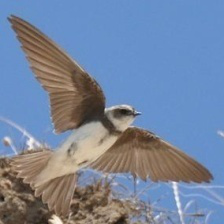

In [16]:
none_trans[2000][0]

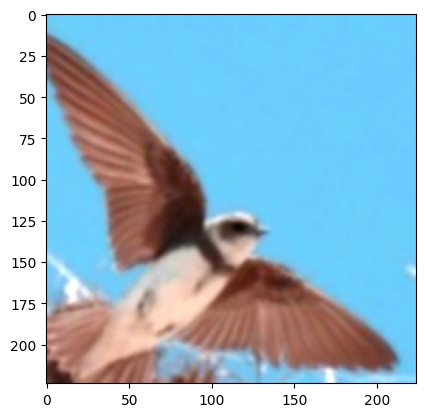

In [18]:
imshow((train_dataset.__getitem__(2000)[0]),resize_train_mean,resize_train_std)